In [1]:
# Libs
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import resnet18
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
import random

In [2]:
class MyImageFolder(datasets.ImageFolder):  
    def __init__(self, root, transform=None, target_transform=None,  
                 loader=datasets.folder.default_loader,  
                 is_valid_file=None):  
        super(MyImageFolder, self).__init__(root, transform, target_transform, loader, is_valid_file)  

    def __getitem__(self, index):  
        sample, target = super(MyImageFolder, self).__getitem__(index)  
        return sample, target, index

In [3]:
# Load data
torch.manual_seed(42)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

normal_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

train_transform2 = transforms.Compose([
    transforms.RandomCrop(224, padding=32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
train_ds = MyImageFolder('mydata/train',
                                transform = train_transform,)
test_ds = datasets.ImageFolder('mydata/test',
                                transform = test_transform,)
batch_size=64
def get_dataloader_workers():
    return 4
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=get_dataloader_workers())
test_dl = DataLoader(test_ds,batch_size=batch_size,shuffle=False,num_workers=get_dataloader_workers())

In [4]:
def displayImg(img):
    npImg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npImg,(1,2,0)))
    plt.show()

tensor(41088)
tensor(8)


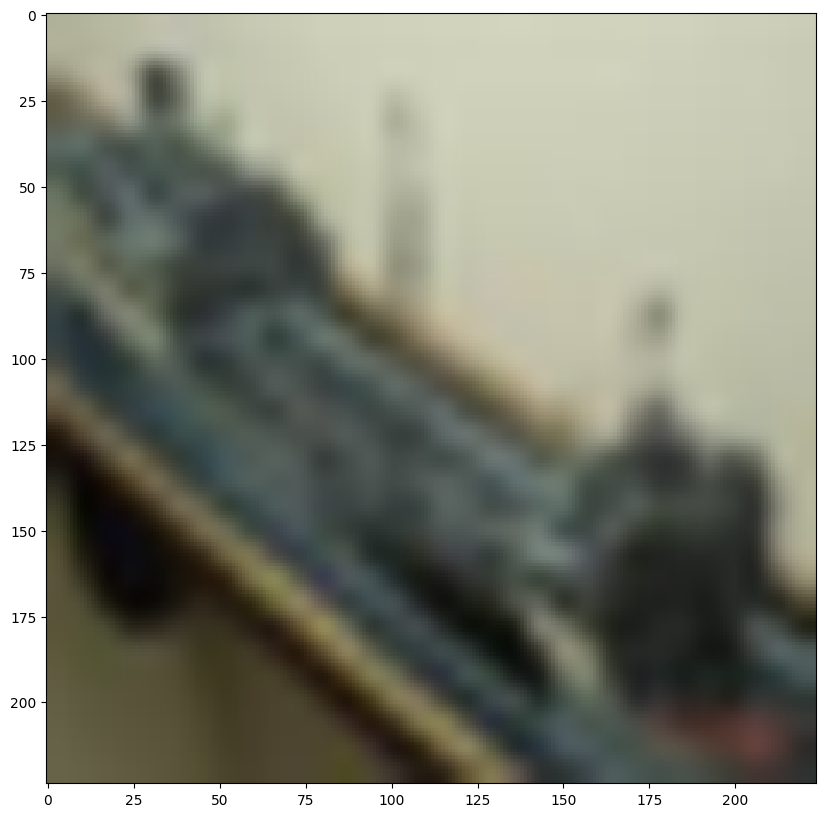

tensor(47912)
tensor(9)


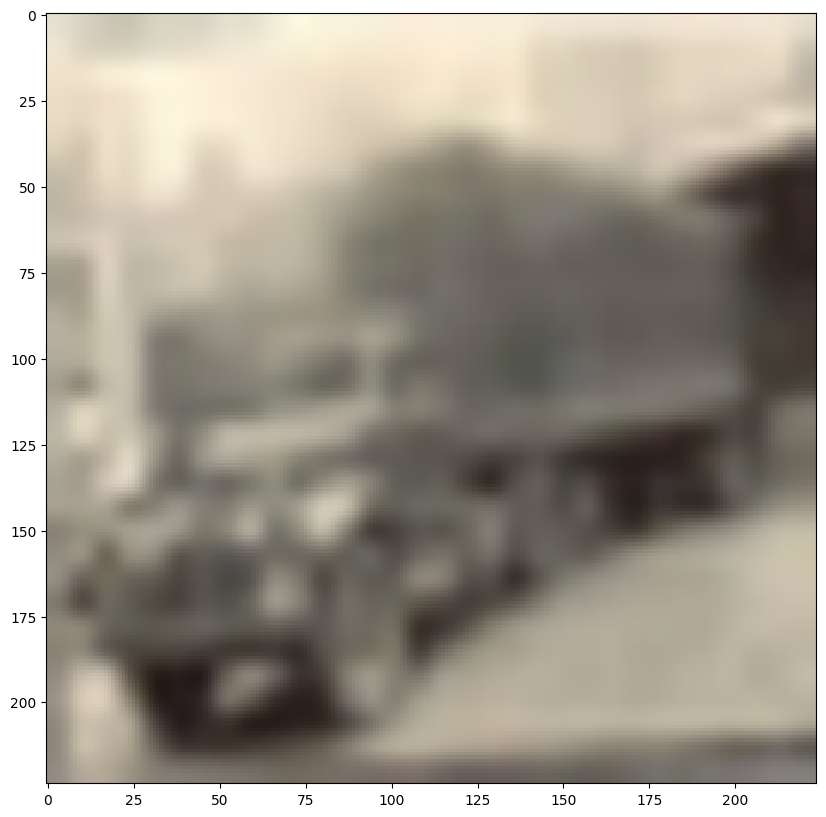

tensor(41033)
tensor(8)


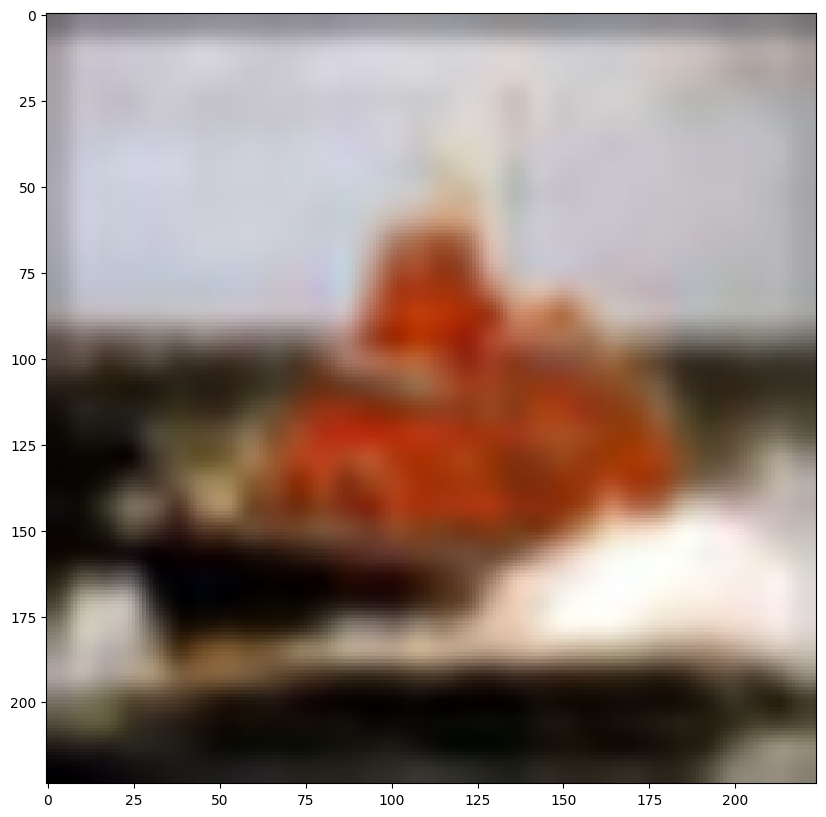

tensor(9267)
tensor(1)


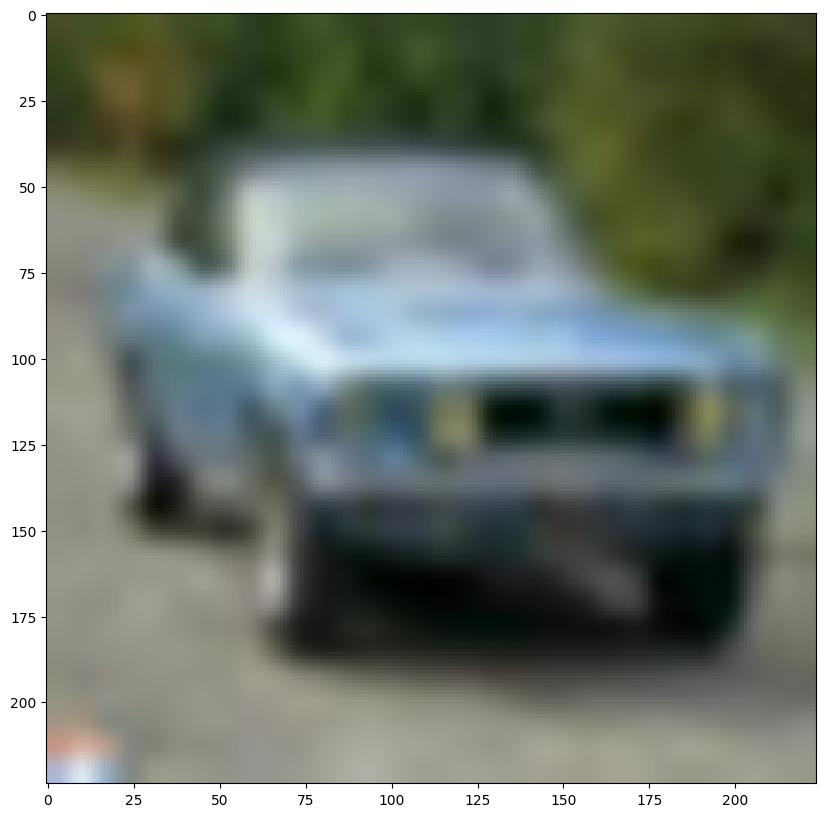

tensor(2702)
tensor(0)


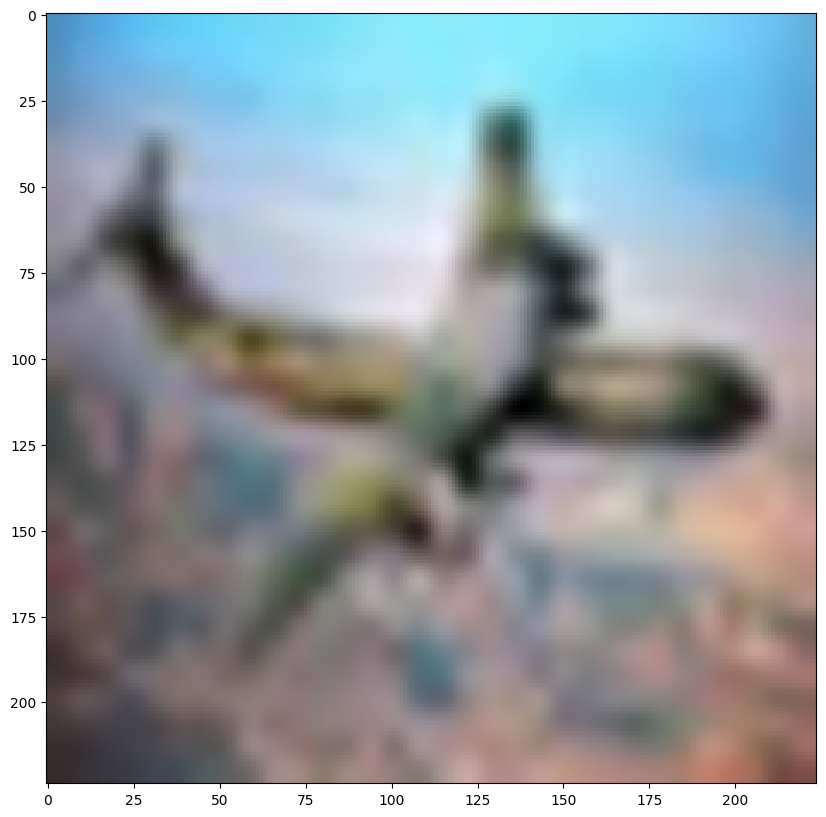

tensor(26895)
tensor(5)


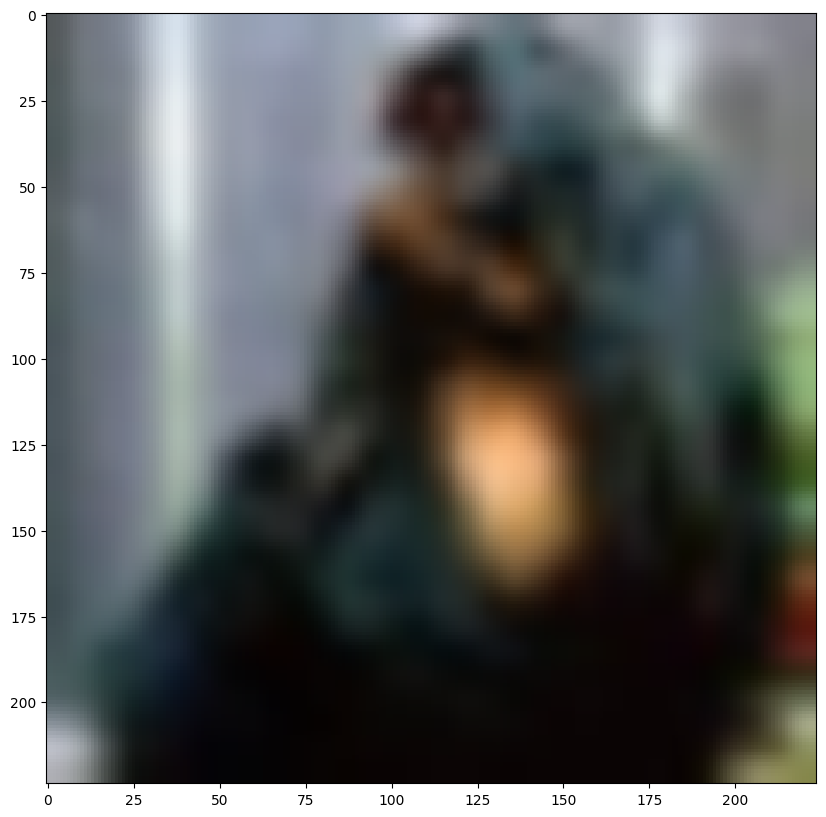

tensor(23580)
tensor(4)


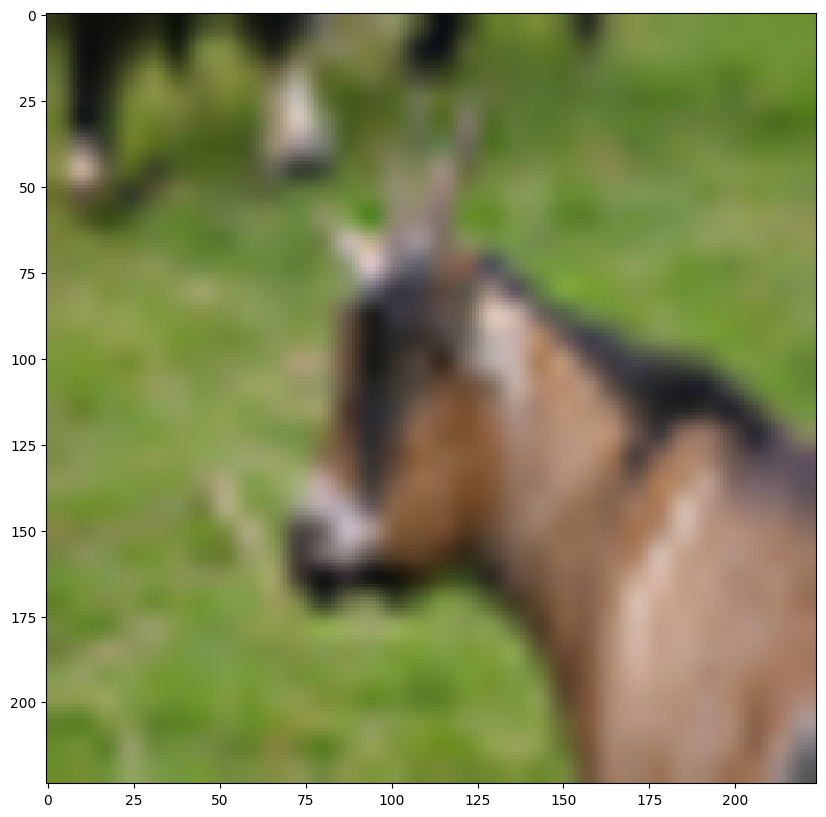

tensor(4043)
tensor(0)


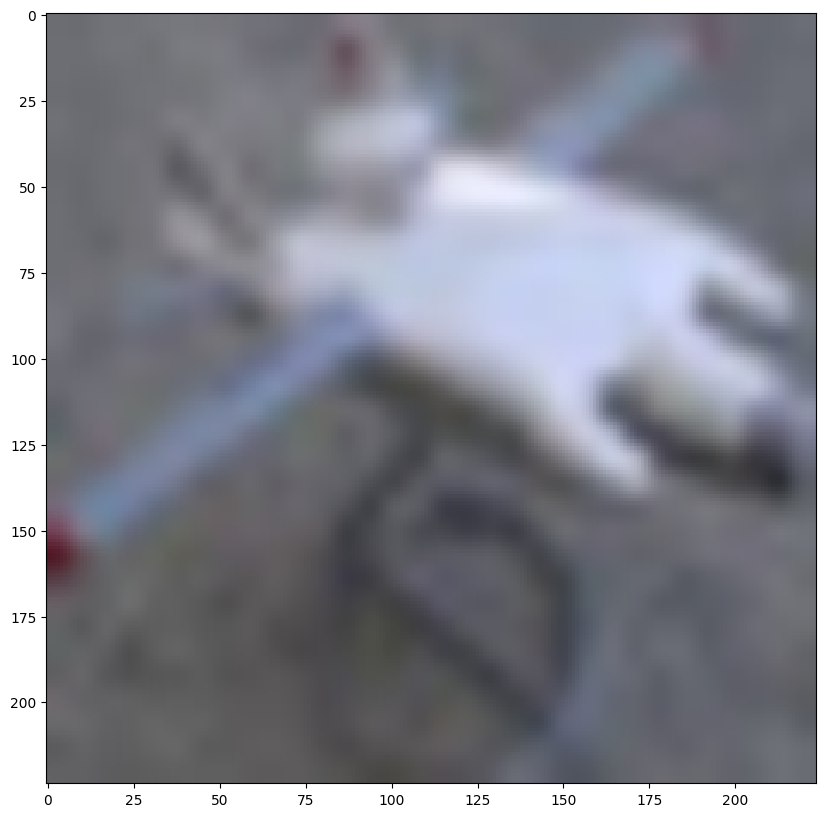

tensor(40579)
tensor(8)


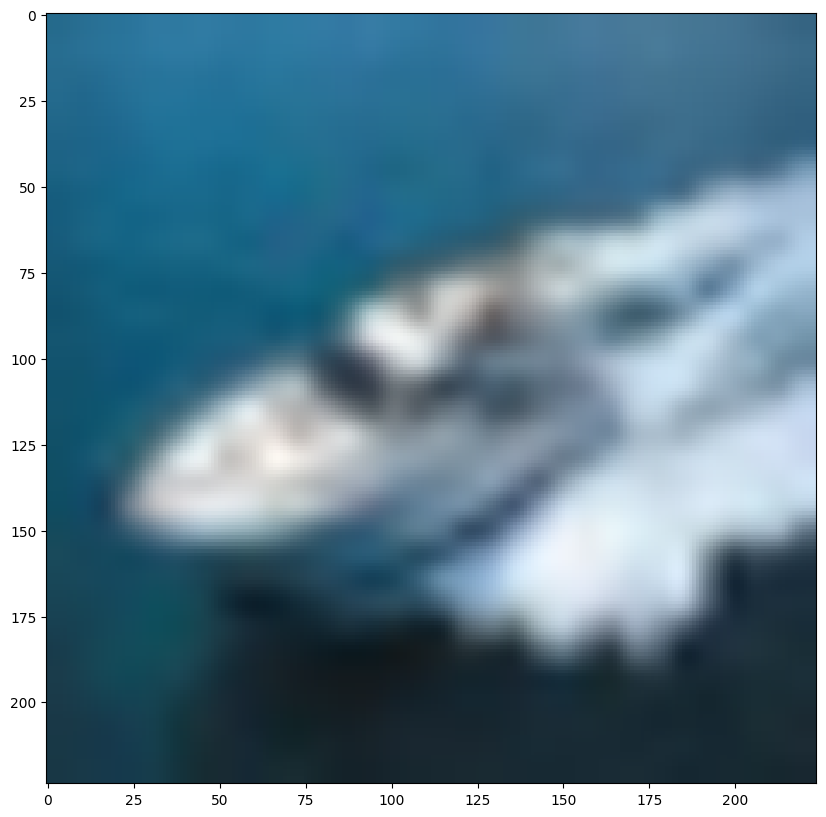

tensor(40132)
tensor(8)


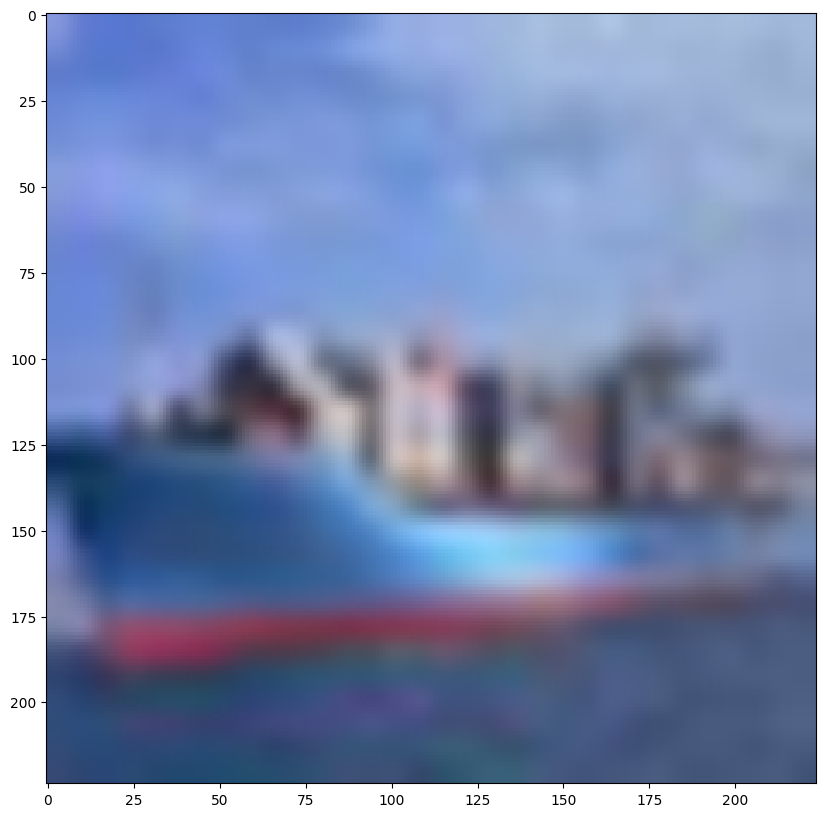

In [5]:
someImages = 0
someLabels = 0
someIndex = 0
i=0
for X,y,index in iter(train_dl):
    someImages=X
    someLabels=y
    someIndex = index
    break

for i in range(0,10):
    print(someIndex[i])
    print(someLabels[i])
    displayImg(someImages[i])

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model=resnet18(num_classes = 10).to(device)
model.load_state_dict(torch.load('best.pkl'))
model.eval()

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#optimizer.load_state_dict(torch.load('optim_data.pkl'))
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=200,eta_min=0.01,last_epoch=-1)

tensor(39992)
tensor(7, device='cuda:0')
tensor([7], device='cuda:0')


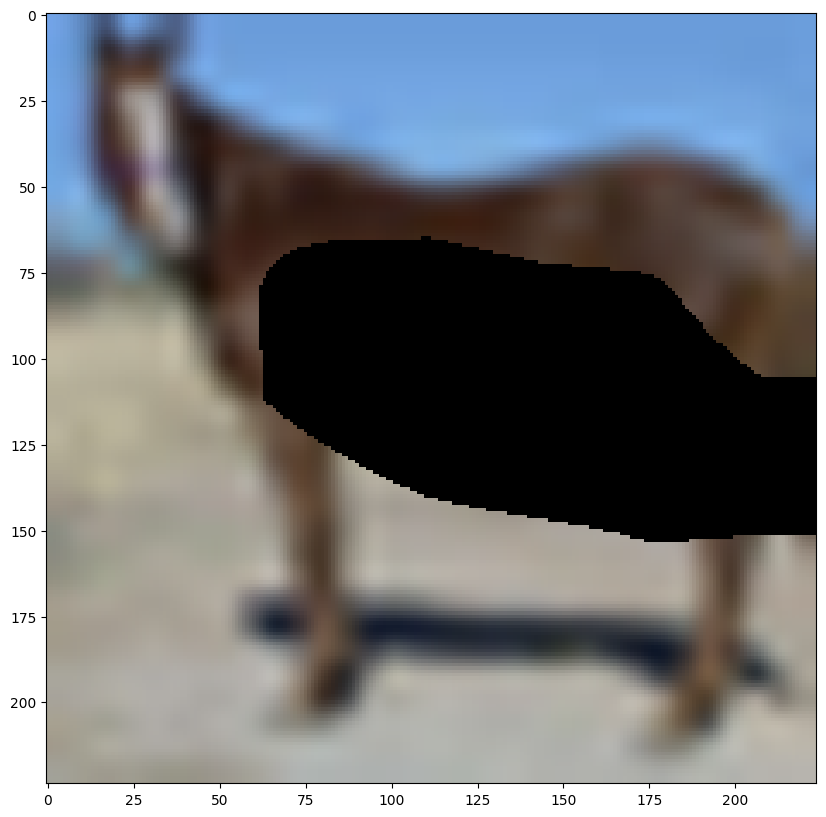

tensor(26804)
tensor(5, device='cuda:0')
tensor([5], device='cuda:0')


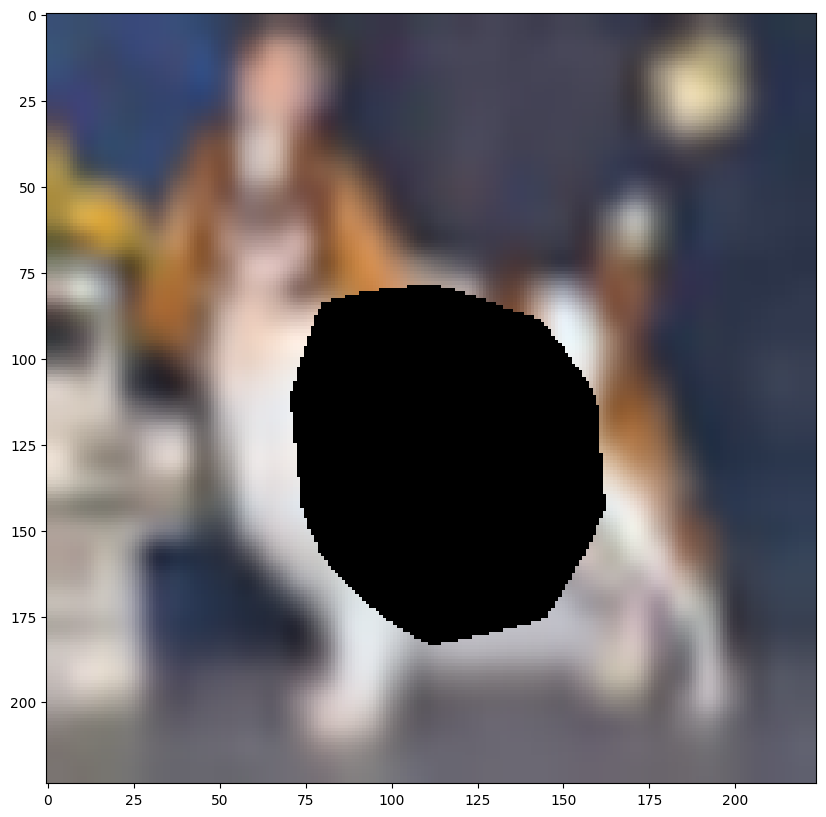

tensor(22395)
tensor(4, device='cuda:0')
tensor([4], device='cuda:0')


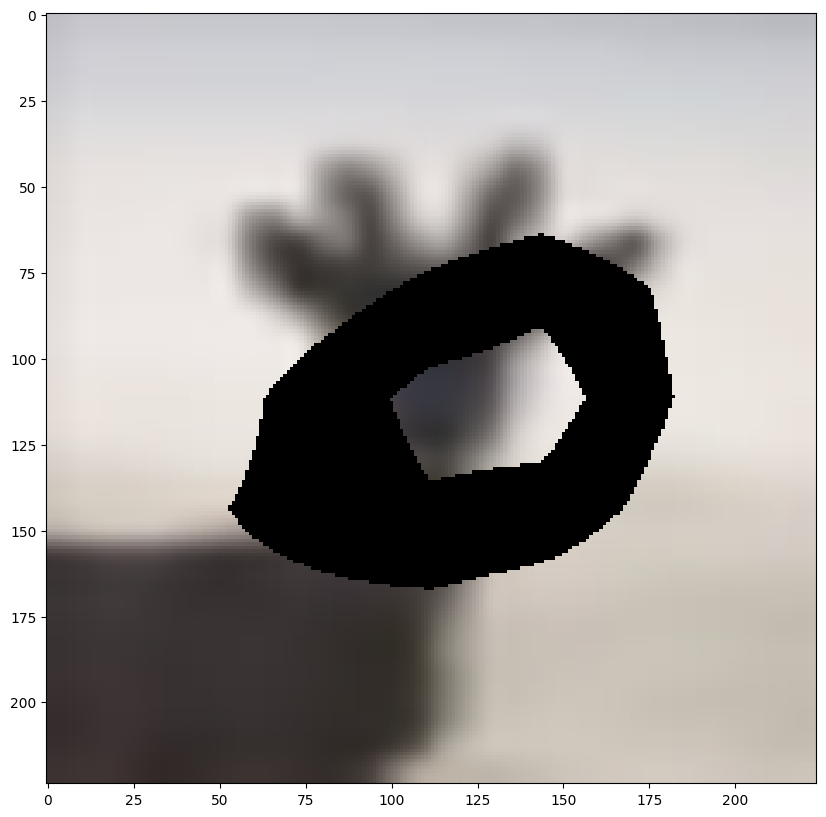

tensor(43222)
tensor(8, device='cuda:0')
tensor([8], device='cuda:0')


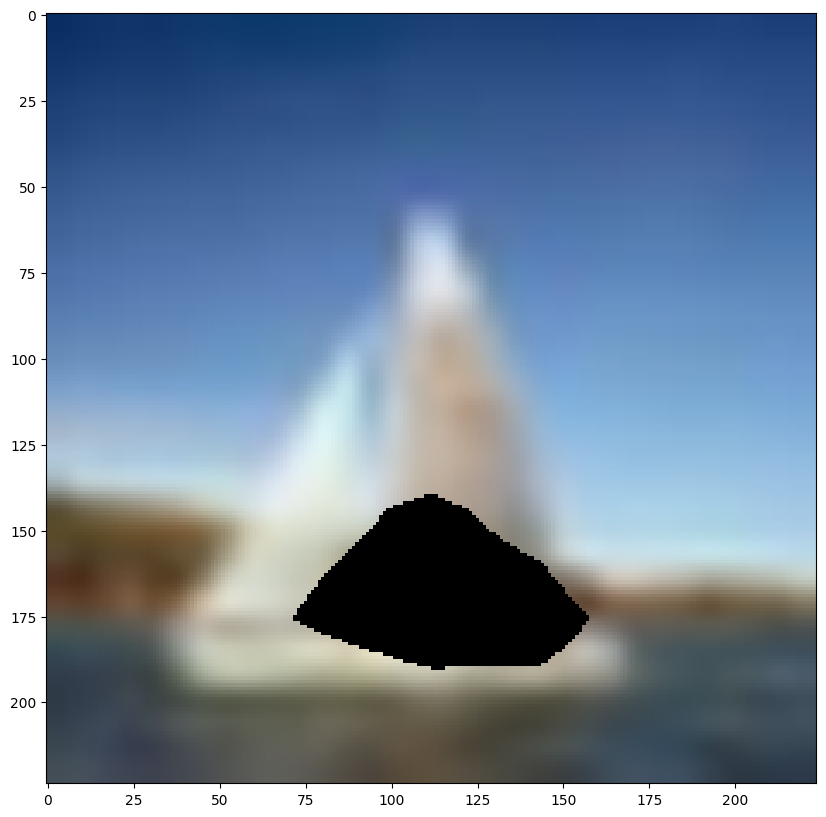

tensor(11966)
tensor(2, device='cuda:0')
tensor([2], device='cuda:0')


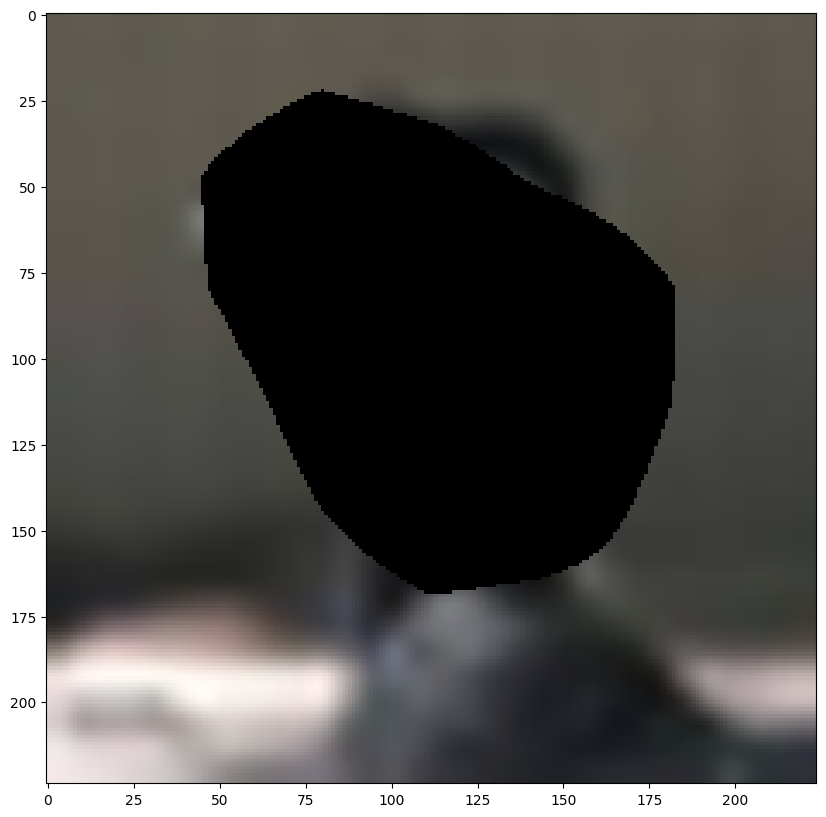

tensor(11422)
tensor(2, device='cuda:0')
tensor([2], device='cuda:0')


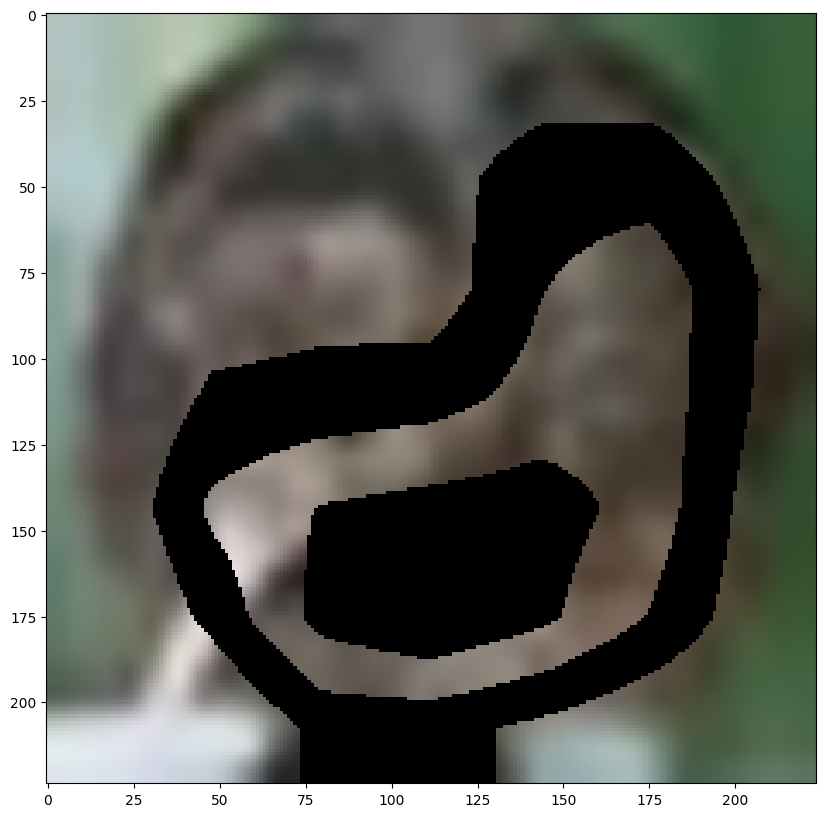

tensor(23857)
tensor(4, device='cuda:0')
tensor([4], device='cuda:0')


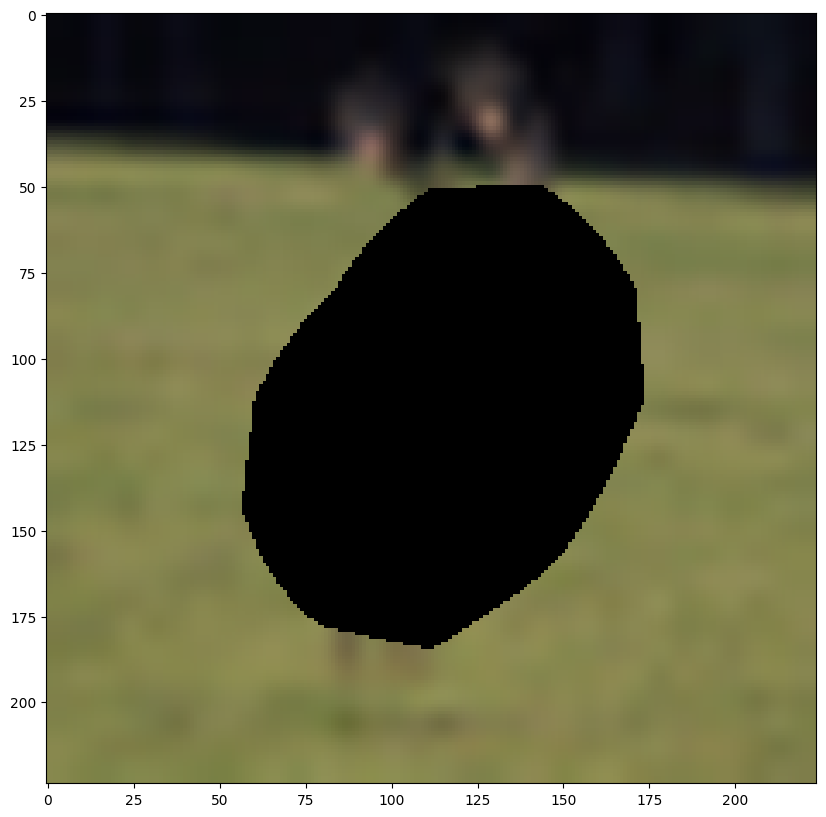

tensor(33462)
tensor(6, device='cuda:0')
tensor([6], device='cuda:0')


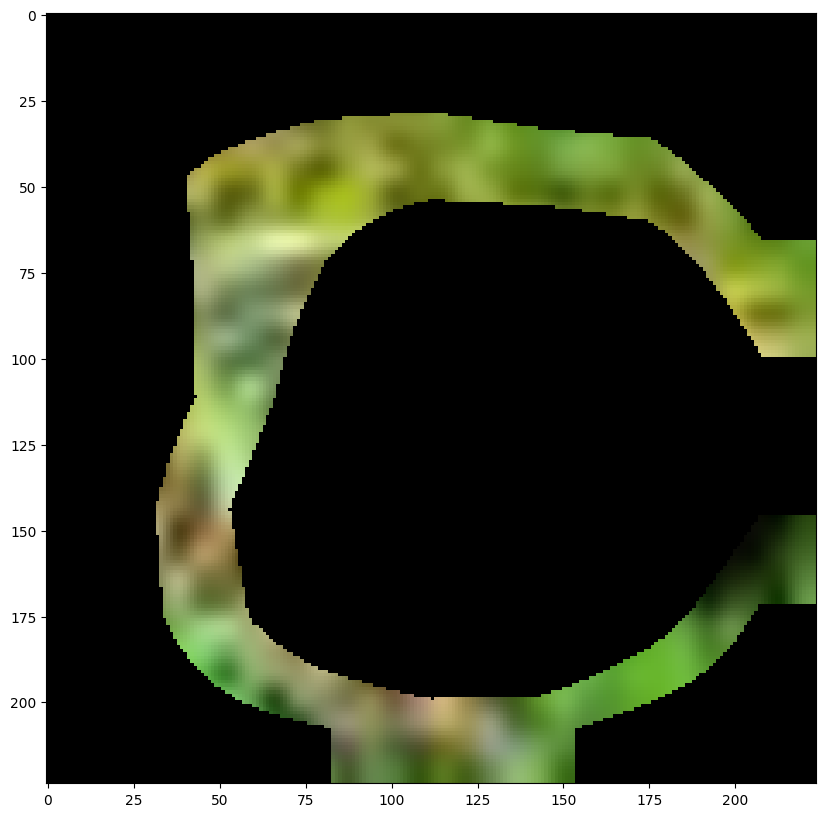

tensor(49032)
tensor(9, device='cuda:0')
tensor([9], device='cuda:0')


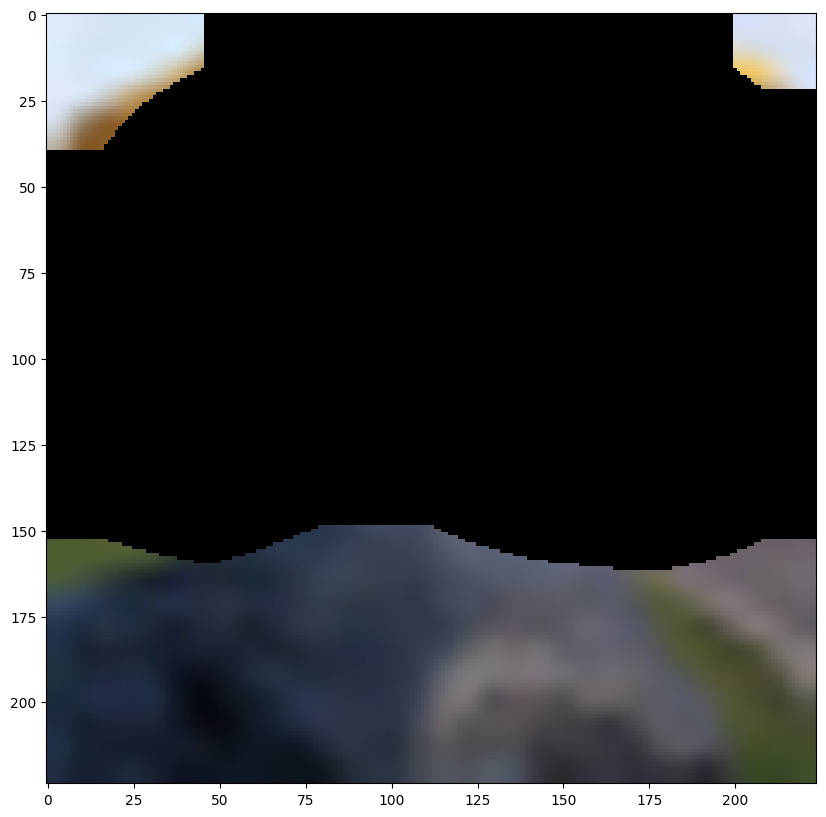

tensor(30939)
tensor(6, device='cuda:0')
tensor([6], device='cuda:0')


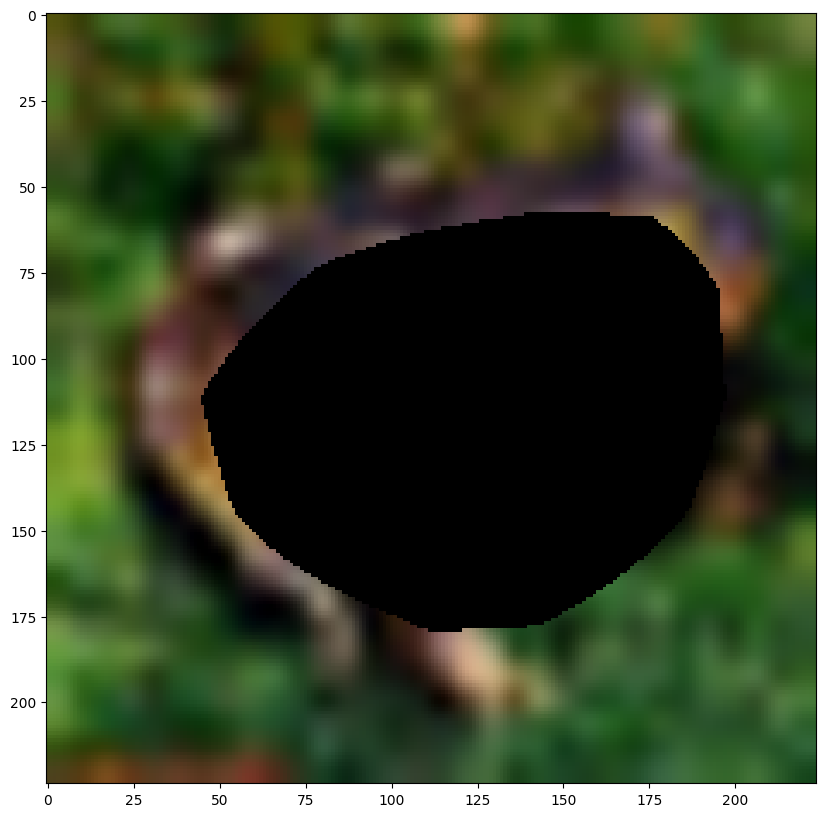

In [9]:
for X,y,index in iter(train_dl):
    X,y = X.to(device),y.to(device)
    normal_X = normal_transform(X).to(device)
    for i in range(10):
        print(index[i])
        print(y[i])
        print(model(normal_X[i:i+1]).argmax(1))
        grayscale_cam = torch.tensor(cv2.imread('./heatmaps/'+str(index[i].item())+'.png', cv2.IMREAD_GRAYSCALE)/255).to(device)
        grayscale_cam = grayscale_cam - 1
        indices8 = (grayscale_cam < -0.75)
        indices6 = (grayscale_cam < -0.55)
        indices4 = (grayscale_cam < -0.35)
        indices2 = (grayscale_cam < -0.15)
        indices0 = (grayscale_cam < 0.05)
        grayscale_cam[indices0] = -1 if random.random()<0.1 else 0
        grayscale_cam[indices2] = -1 if random.random()<0.15 else 0
        grayscale_cam[indices4] = -1 if random.random()<0.4 else 0
        grayscale_cam[indices6] = -1 if random.random()<0.6 else 0
        grayscale_cam[indices8] = 0
        X[i,:] += grayscale_cam
        X[i,:,indices8] = 0 if random.random()<0.8 else X[i,:,indices8]
        X[i] = torch.clamp(X[i],0,1)
        displayImg(X[i].cpu())
    break

In [11]:
class TrainImageFolder(datasets.ImageFolder):  
    def __init__(self, root, transform=None, target_transform=None,  
                 loader=datasets.folder.default_loader,  
                 is_valid_file=None):  
        super(TrainImageFolder, self).__init__(root, transform, target_transform, loader, is_valid_file)  

    def __getitem__(self, index):  
        sample, target = super(TrainImageFolder, self).__getitem__(index)  
        heatmap = self.transform(self.loader('/hy-tmp/heatmaps/'+str(index)+'.png'))
        return sample, target, heatmap

train_ds = TrainImageFolder('mydata/train',
                                transform = train_transform,)
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=get_dataloader_workers())

tensor(9)


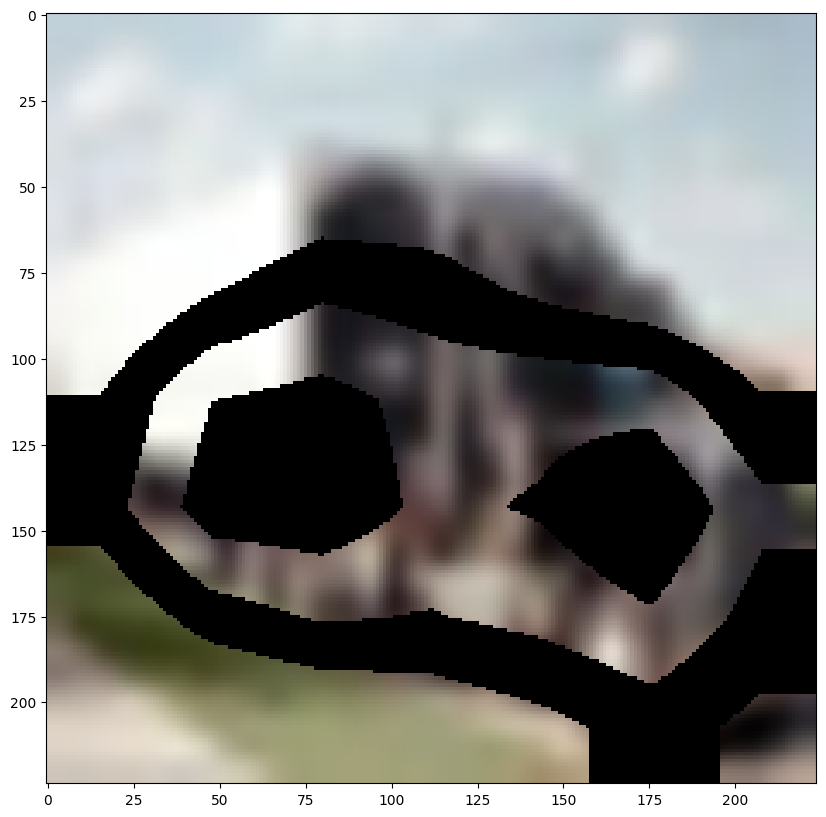

tensor(0)


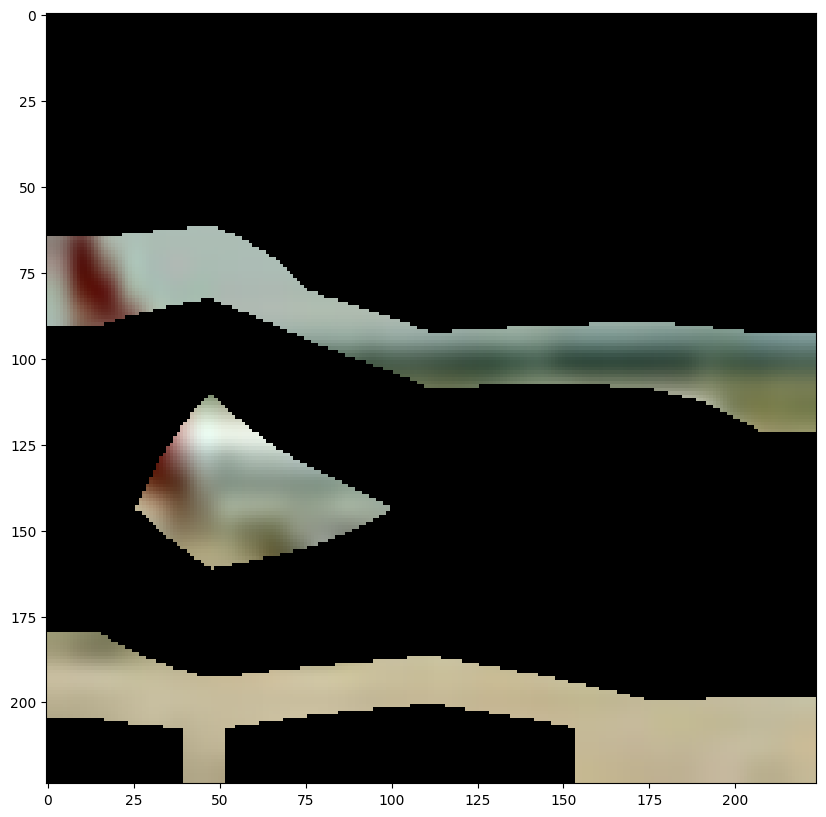

tensor(5)


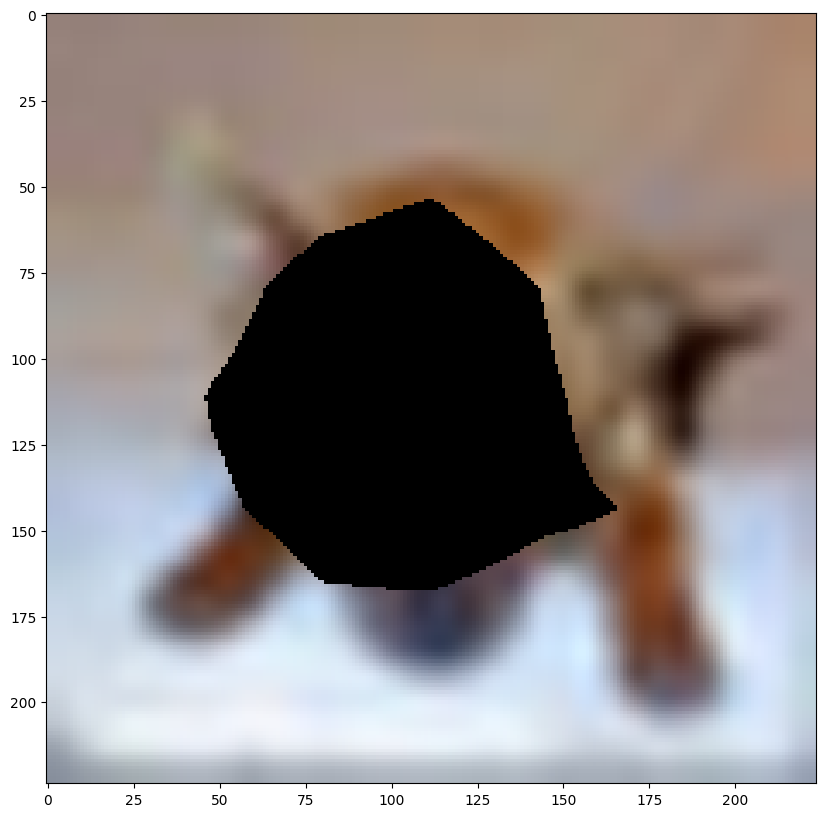

tensor(3)


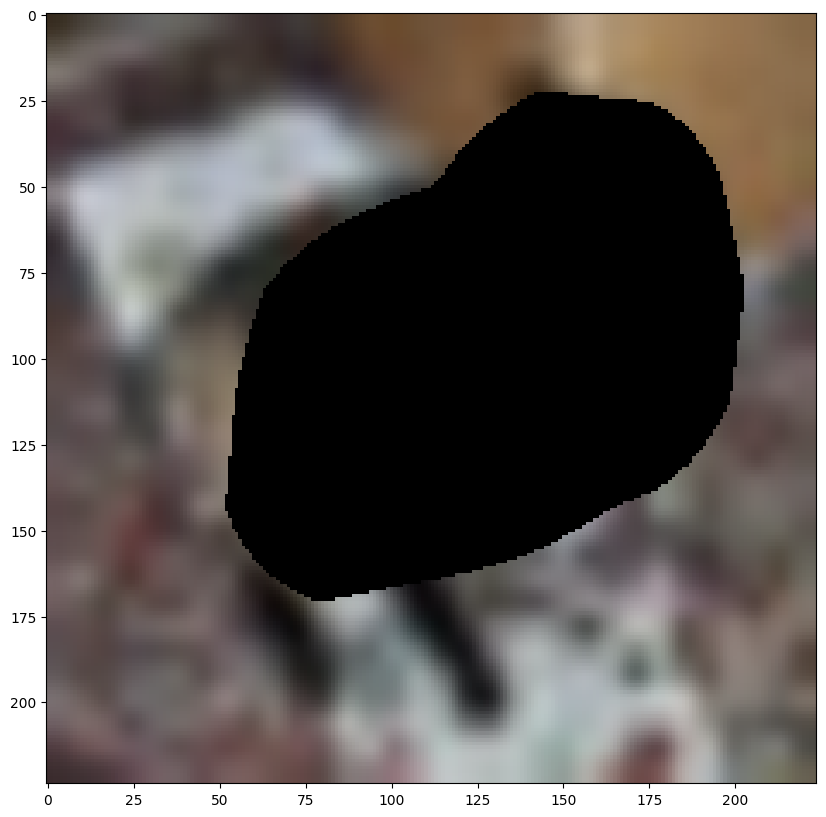

tensor(7)


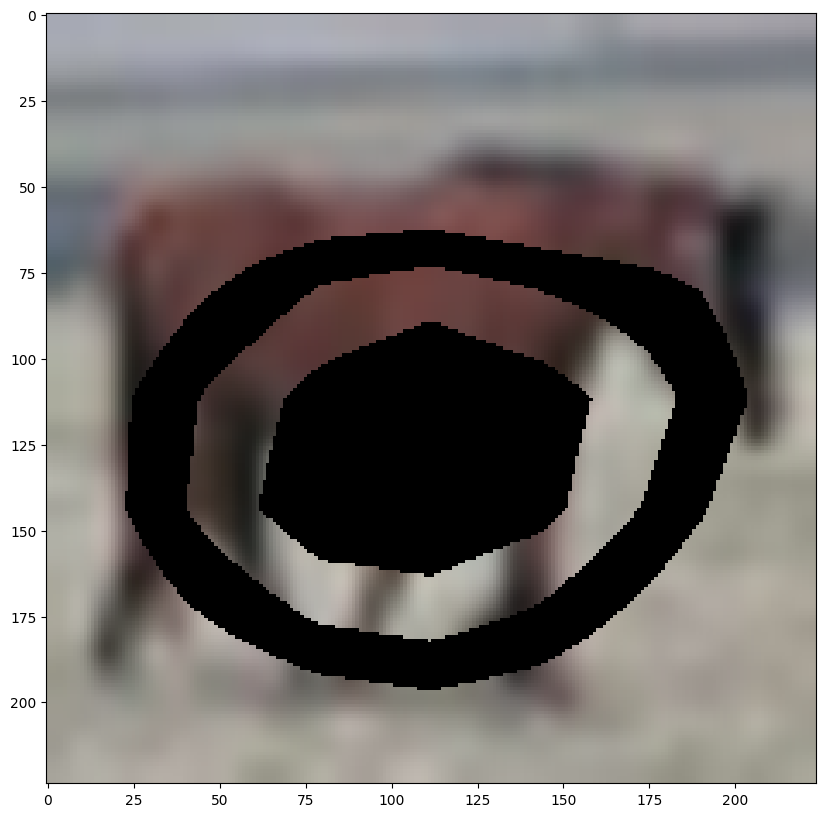

tensor(6)


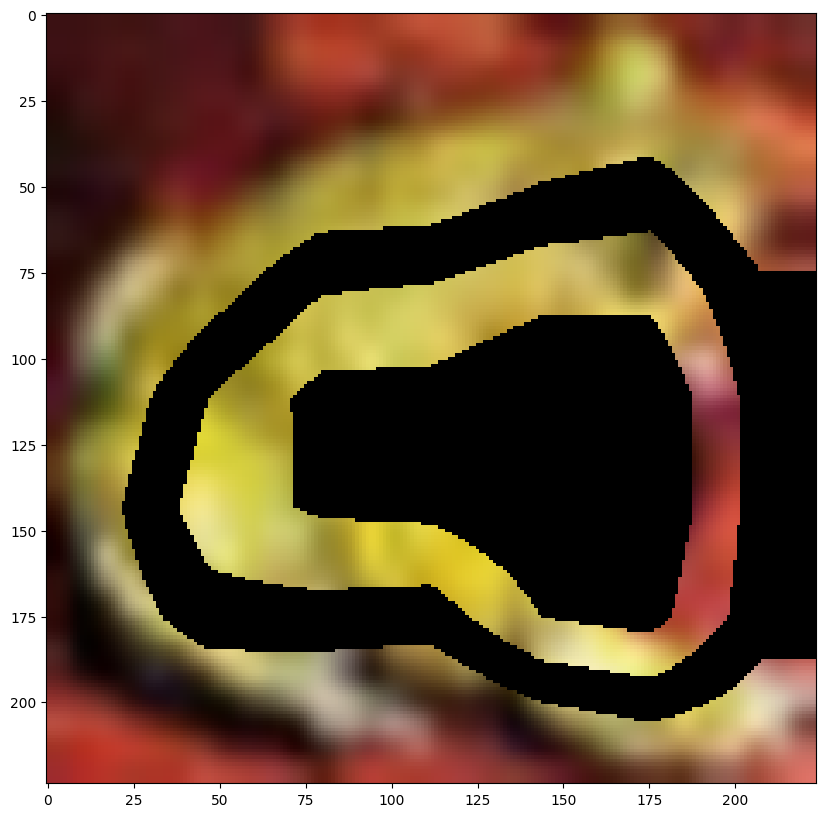

tensor(8)


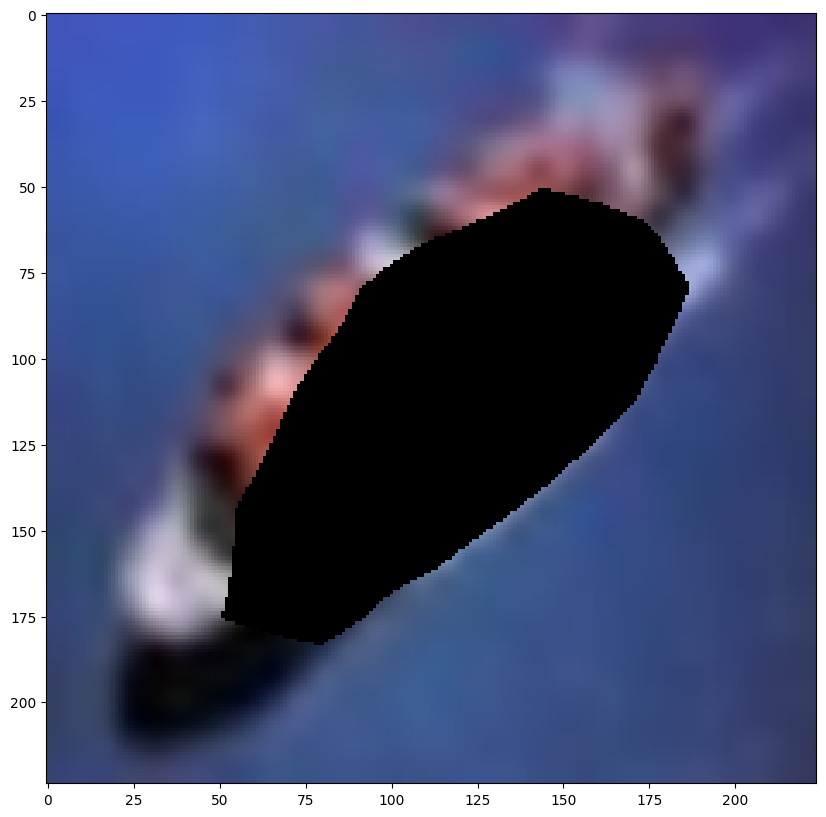

tensor(9)


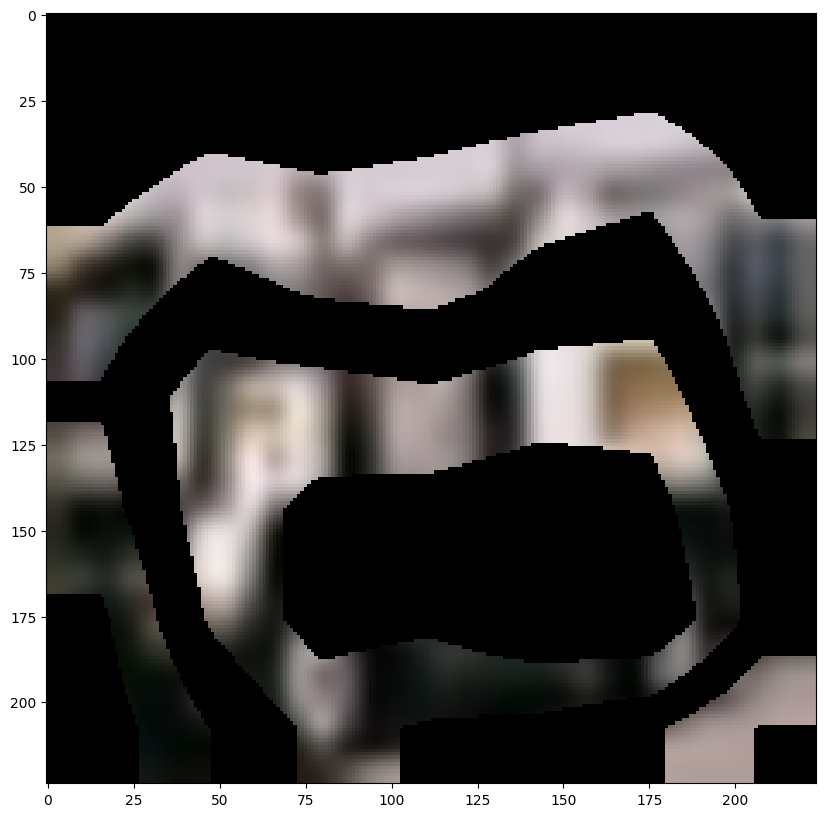

tensor(5)


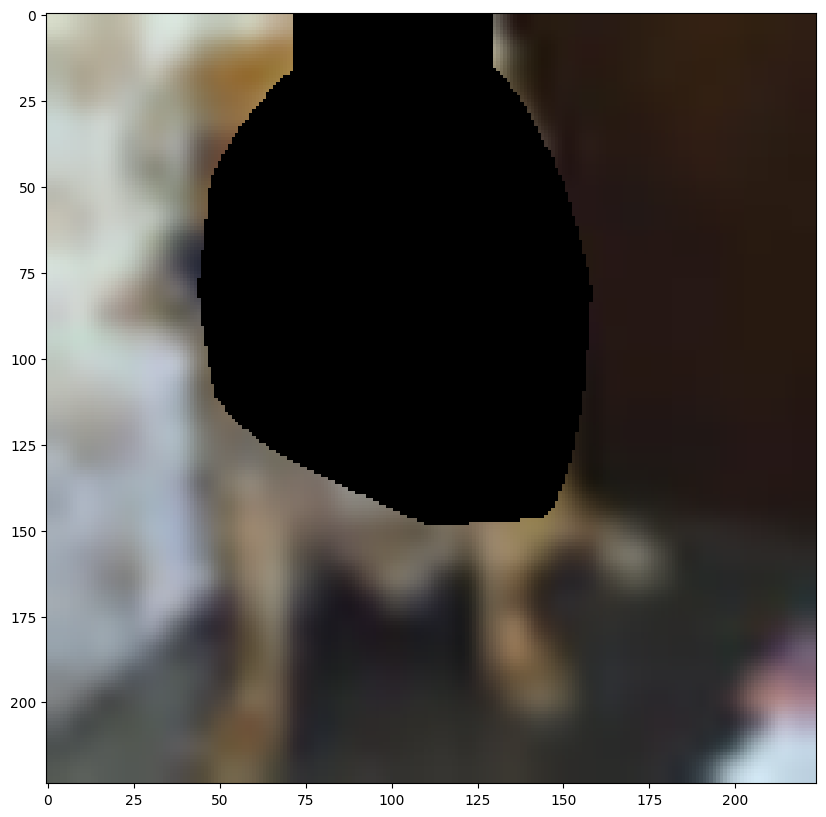

tensor(0)


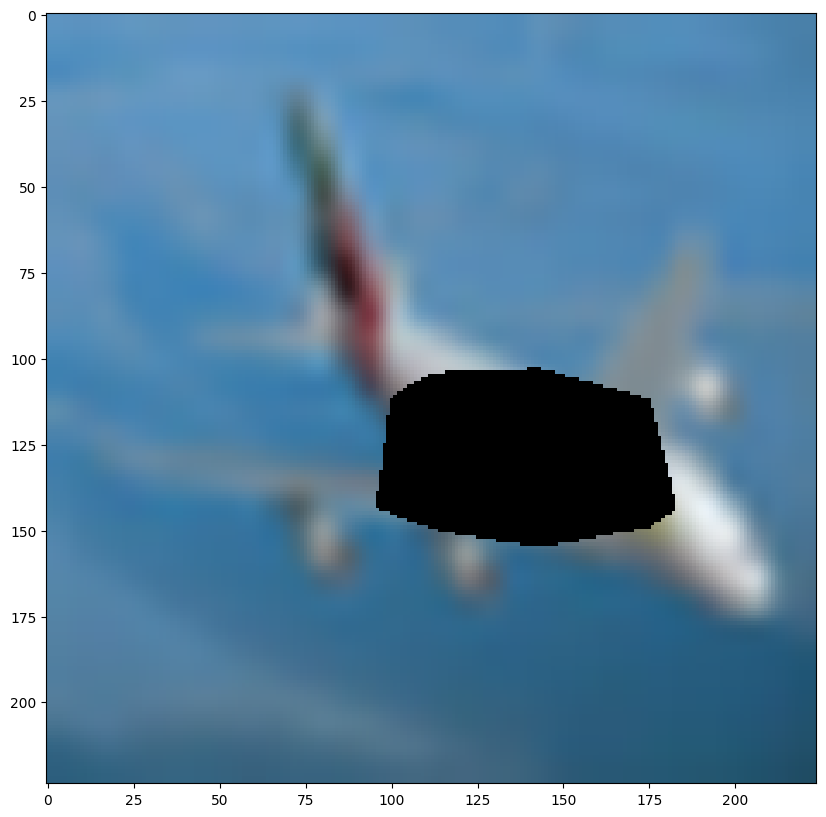

In [12]:
someImages = 0
someLabels = 0
someMasks = 0
i=0
for X,y,M in iter(train_dl):
    someImages=X
    someLabels=y
    someMasks = M
    break

for i in range(0,10):
    print(someLabels[i])
    someMasks[i]-=1
    indices8 = (someMasks[i] < -0.75)
    indices6 = (someMasks[i] < -0.55)
    indices4 = (someMasks[i] < -0.35)
    indices2 = (someMasks[i] < -0.15)
    indices0 = (someMasks[i] < 0.05)
    someMasks[i][indices0] = -1 if random.random()<0.1 else 0
    someMasks[i][indices2] = -1 if random.random()<0.15 else 0
    someMasks[i][indices4] = -1 if random.random()<0.4 else 0
    someMasks[i][indices6] = -1 if random.random()<0.6 else 0
    someMasks[i][indices8] = 0
    someImages[i] += someMasks[i]
    someImages[i,indices8] = 0 if random.random()<0.8 else someImages[i,indices8]
    someImages[i] = torch.clamp(someImages[i],0,1)
    displayImg(someImages[i])

In [13]:
def train_gaussian(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    train_accuracy =0
    model.train()
    for X,y,grayscale_cam in tqdm(dataloader):
        X,y,grayscale_cam = X.to(device), y.to(device), grayscale_cam.to(device)
        for j in range(len(X)):
            grayscale_cam[j]-=1
            indices8 = (grayscale_cam[j] < -0.75)
            indices6 = (grayscale_cam[j] < -0.55)
            indices4 = (grayscale_cam[j] < -0.35)
            indices2 = (grayscale_cam[j] < -0.15)
            indices0 = (grayscale_cam[j] < 0.05)
            grayscale_cam[j][indices2] = -1 if random.random()<0.2 else 0
            grayscale_cam[j][indices4] = -1 if random.random()<0.4 else 0
            grayscale_cam[j][indices6] = -1 if random.random()<0.6 else 0
            grayscale_cam[j][indices8] = 0
            X[j] += grayscale_cam[j]
            X[j,indices8] = 0 if random.random()<0.8 else X[j,indices8]
            X[j] = torch.clamp(X[j],0,1)
        
        X = train_transform2(X)
        # compute prediction
        predict = model(X)
        # compute loss
        loss = loss_fn(predict,y)
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        optimizer.step()
        # record loss
        train_loss += loss.item()
        train_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
    return train_loss,train_accuracy/size

def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    train_accuracy =0
    model.train()
    for X,y,index in tqdm(dataloader):
        X,y = X.to(device), y.to(device)
        X = train_transform2(X)
        # compute prediction
        predict = model(X)
        # compute loss
        loss = loss_fn(predict,y)
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        optimizer.step()
        # record loss
        train_loss += loss.item()
        train_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()  
    return train_loss,train_accuracy/size

def test(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for X,y in tqdm(dataloader):
            X = X.to(device)
            y = y.to(device)
            predict = model(X)
            loss = loss_fn(predict,y)
            test_loss += loss.item()
            test_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
            
    return test_loss,test_accuracy/size

In [14]:
epochs = 75
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train_gaussian(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)

Epoch, 0


100%|██████████| 157/157 [00:06<00:00, 24.07it/s]


train_loss: 270.76660645380616   train_accuracy: 88.336
test_loss: 53.81471497891471   test_accuracy: 90.99000000000001
Epoch, 1


100%|██████████| 157/157 [00:06<00:00, 23.43it/s]


train_loss: 206.1149423457682   train_accuracy: 90.742
test_loss: 66.72764100856148   test_accuracy: 89.32
Epoch, 2


100%|██████████| 157/157 [00:06<00:00, 23.53it/s]


train_loss: 194.22400505840778   train_accuracy: 91.396
test_loss: 74.01041409280151   test_accuracy: 88.44
Epoch, 3


100%|██████████| 157/157 [00:06<00:00, 23.86it/s]


train_loss: 180.3469075895846   train_accuracy: 91.988
test_loss: 100.48045722520328   test_accuracy: 85.11
Epoch, 4


100%|██████████| 157/157 [00:06<00:00, 23.86it/s]


train_loss: 179.24687308445573   train_accuracy: 91.918
test_loss: 82.90562197100371   test_accuracy: 87.29
Epoch, 5


100%|██████████| 157/157 [00:06<00:00, 23.59it/s]


train_loss: 169.35238065943122   train_accuracy: 92.326
test_loss: 62.38561073911842   test_accuracy: 90.24
Epoch, 6


100%|██████████| 157/157 [00:06<00:00, 23.85it/s]


train_loss: 170.47039826586843   train_accuracy: 92.31200000000001
test_loss: 75.66922579705715   test_accuracy: 87.79
Epoch, 7


100%|██████████| 157/157 [00:06<00:00, 24.10it/s]


train_loss: 160.52052019909024   train_accuracy: 92.73599999999999
test_loss: 74.55074674636126   test_accuracy: 88.24
Epoch, 8


100%|██████████| 157/157 [00:06<00:00, 23.61it/s]


train_loss: 156.24096141383052   train_accuracy: 92.918
test_loss: 77.97545934002846   test_accuracy: 87.38
Epoch, 9


100%|██████████| 157/157 [00:06<00:00, 23.46it/s]


train_loss: 154.0923507362604   train_accuracy: 93.04
test_loss: 63.60956703685224   test_accuracy: 90.21000000000001
Epoch, 10


100%|██████████| 157/157 [00:06<00:00, 23.87it/s]


train_loss: 152.36873173341155   train_accuracy: 93.144
test_loss: 66.34533997951075   test_accuracy: 89.71000000000001
Epoch, 11


100%|██████████| 157/157 [00:06<00:00, 23.11it/s]


train_loss: 146.3295213356614   train_accuracy: 93.43
test_loss: 59.77078370936215   test_accuracy: 90.28
Epoch, 12


100%|██████████| 157/157 [00:06<00:00, 24.14it/s]


train_loss: 145.4334203246981   train_accuracy: 93.298
test_loss: 80.39424467273057   test_accuracy: 87.67
Epoch, 13


100%|██████████| 157/157 [00:06<00:00, 23.93it/s]


train_loss: 141.83003268390894   train_accuracy: 93.582
test_loss: 76.47830742970109   test_accuracy: 88.48
Epoch, 14


100%|██████████| 157/157 [00:06<00:00, 22.94it/s]


train_loss: 141.46624063327909   train_accuracy: 93.658
test_loss: 65.46487211622298   test_accuracy: 89.64
Epoch, 15


100%|██████████| 157/157 [00:06<00:00, 23.45it/s]


train_loss: 132.52555381134152   train_accuracy: 94.07
test_loss: 97.8980948147364   test_accuracy: 85.59
Epoch, 16


100%|██████████| 157/157 [00:06<00:00, 23.84it/s]


train_loss: 138.28121015429497   train_accuracy: 93.726
test_loss: 53.961433932418004   test_accuracy: 91.25
Epoch, 17


100%|██████████| 157/157 [00:06<00:00, 23.82it/s]


train_loss: 136.3238219935447   train_accuracy: 93.88
test_loss: 83.74793101428077   test_accuracy: 87.13
Epoch, 18


100%|██████████| 157/157 [00:06<00:00, 23.89it/s]


train_loss: 129.49633629992604   train_accuracy: 94.248
test_loss: 66.61364138079807   test_accuracy: 89.9
Epoch, 19


100%|██████████| 157/157 [00:06<00:00, 23.81it/s]


train_loss: 133.84088103100657   train_accuracy: 93.94200000000001
test_loss: 86.76438787975349   test_accuracy: 87.49
Epoch, 20


100%|██████████| 157/157 [00:06<00:00, 24.33it/s]


train_loss: 130.6579479686916   train_accuracy: 94.134
test_loss: 73.9530831053853   test_accuracy: 89.52
Epoch, 21


100%|██████████| 157/157 [00:06<00:00, 23.79it/s]


train_loss: 126.45230310130864   train_accuracy: 94.222
test_loss: 56.57132173614809   test_accuracy: 91.11
Epoch, 22


100%|██████████| 157/157 [00:06<00:00, 23.75it/s]


train_loss: 125.16321818996221   train_accuracy: 94.388
test_loss: 112.92422321811318   test_accuracy: 84.14
Epoch, 23


100%|██████████| 157/157 [00:06<00:00, 23.51it/s]


train_loss: 124.85481837950647   train_accuracy: 94.37
test_loss: 109.65880579656869   test_accuracy: 85.92
Epoch, 24


100%|██████████| 157/157 [00:06<00:00, 23.55it/s]


train_loss: 123.44689915515482   train_accuracy: 94.382
test_loss: 78.22463374503423   test_accuracy: 89.51
Epoch, 25


100%|██████████| 157/157 [00:06<00:00, 23.59it/s]


train_loss: 121.99343087989837   train_accuracy: 94.48
test_loss: 58.875995713984594   test_accuracy: 91.2
Epoch, 26


100%|██████████| 157/157 [00:06<00:00, 23.42it/s]


train_loss: 121.86591423861682   train_accuracy: 94.554
test_loss: 69.24888465524418   test_accuracy: 89.86
Epoch, 27


100%|██████████| 157/157 [00:06<00:00, 24.18it/s]


train_loss: 118.18340801820159   train_accuracy: 94.688
test_loss: 71.1236891351873   test_accuracy: 89.7
Epoch, 28


100%|██████████| 157/157 [00:06<00:00, 24.12it/s]


train_loss: 119.09913465753198   train_accuracy: 94.596
test_loss: 70.4875407598447   test_accuracy: 89.62
Epoch, 29


100%|██████████| 157/157 [00:06<00:00, 23.61it/s]


train_loss: 116.59104377403855   train_accuracy: 94.748
test_loss: 87.5040401503793   test_accuracy: 87.53
Epoch, 30


100%|██████████| 157/157 [00:06<00:00, 23.89it/s]


train_loss: 114.33481655269861   train_accuracy: 94.868
test_loss: 68.39332352922065   test_accuracy: 89.87
Epoch, 31


100%|██████████| 157/157 [00:06<00:00, 23.30it/s]


train_loss: 112.04123674146831   train_accuracy: 94.882
test_loss: 66.05822372157127   test_accuracy: 90.03999999999999
Epoch, 32


100%|██████████| 157/157 [00:06<00:00, 24.05it/s]


train_loss: 114.43633761629462   train_accuracy: 94.896
test_loss: 81.53256020648405   test_accuracy: 88.11
Epoch, 33


100%|██████████| 157/157 [00:06<00:00, 23.95it/s]


train_loss: 109.88452254515141   train_accuracy: 95.1
test_loss: 73.99247478460893   test_accuracy: 89.42999999999999
Epoch, 34


100%|██████████| 157/157 [00:06<00:00, 24.12it/s]


train_loss: 112.58125754073262   train_accuracy: 95.068
test_loss: 64.47715262323618   test_accuracy: 90.57
Epoch, 35


100%|██████████| 157/157 [00:06<00:00, 23.67it/s]


train_loss: 106.50978485308588   train_accuracy: 95.236
test_loss: 77.80426727980375   test_accuracy: 88.72
Epoch, 36


100%|██████████| 157/157 [00:06<00:00, 23.61it/s]


train_loss: 109.5936251571402   train_accuracy: 95.05799999999999
test_loss: 75.30956275546123   test_accuracy: 89.23
Epoch, 37


100%|██████████| 157/157 [00:06<00:00, 23.67it/s]


train_loss: 107.68084115535021   train_accuracy: 95.152
test_loss: 78.6343773715198   test_accuracy: 88.69
Epoch, 38


100%|██████████| 157/157 [00:06<00:00, 23.98it/s]


train_loss: 103.7606451837346   train_accuracy: 95.372
test_loss: 112.70465914905071   test_accuracy: 85.42
Epoch, 39


100%|██████████| 157/157 [00:06<00:00, 23.69it/s]


train_loss: 104.47178615722805   train_accuracy: 95.324
test_loss: 119.88136083539575   test_accuracy: 84.93
Epoch, 40


100%|██████████| 157/157 [00:06<00:00, 23.81it/s]


train_loss: 105.57864420767874   train_accuracy: 95.146
test_loss: 70.0719108976773   test_accuracy: 89.56
Epoch, 41


100%|██████████| 157/157 [00:06<00:00, 23.93it/s]


train_loss: 104.22908605635166   train_accuracy: 95.21
test_loss: 71.68203012272716   test_accuracy: 89.60000000000001
Epoch, 42


100%|██████████| 157/157 [00:06<00:00, 23.33it/s]


train_loss: 103.72098931856453   train_accuracy: 95.218
test_loss: 74.60570667500724   test_accuracy: 89.67
Epoch, 43


100%|██████████| 157/157 [00:06<00:00, 23.43it/s]


train_loss: 95.59013680089265   train_accuracy: 95.724
test_loss: 81.81707455776632   test_accuracy: 88.22
Epoch, 44


100%|██████████| 157/157 [00:06<00:00, 24.04it/s]


train_loss: 101.11163489334285   train_accuracy: 95.43599999999999
test_loss: 74.96045607328415   test_accuracy: 88.96
Epoch, 45


100%|██████████| 157/157 [00:06<00:00, 23.56it/s]


train_loss: 101.48263390175998   train_accuracy: 95.494
test_loss: 94.48839968442917   test_accuracy: 87.96000000000001
Epoch, 46


100%|██████████| 157/157 [00:06<00:00, 23.02it/s]


train_loss: 99.77873299457133   train_accuracy: 95.474
test_loss: 74.82249175244942   test_accuracy: 89.72
Epoch, 47


100%|██████████| 157/157 [00:06<00:00, 23.67it/s]


train_loss: 97.46635744348168   train_accuracy: 95.592
test_loss: 72.45289120124653   test_accuracy: 89.92999999999999
Epoch, 48


100%|██████████| 157/157 [00:06<00:00, 23.85it/s]


train_loss: 95.29247224703431   train_accuracy: 95.65599999999999
test_loss: 67.18048849824117   test_accuracy: 90.52
Epoch, 49


100%|██████████| 157/157 [00:06<00:00, 23.52it/s]


train_loss: 93.37396629760042   train_accuracy: 95.824
test_loss: 101.05782753927633   test_accuracy: 86.8
Epoch, 50


100%|██████████| 157/157 [00:06<00:00, 23.28it/s]


train_loss: 95.04325844161212   train_accuracy: 95.674
test_loss: 60.994910389286815   test_accuracy: 91.09
Epoch, 51


100%|██████████| 157/157 [00:06<00:00, 23.74it/s]


train_loss: 97.18265599757433   train_accuracy: 95.634
test_loss: 77.12121395021677   test_accuracy: 89.73
Epoch, 52


100%|██████████| 157/157 [00:06<00:00, 24.09it/s]


train_loss: 96.4236381193623   train_accuracy: 95.624
test_loss: 81.19594588672044   test_accuracy: 89.28
Epoch, 53


100%|██████████| 157/157 [00:06<00:00, 23.50it/s]


train_loss: 94.88199579995126   train_accuracy: 95.67999999999999
test_loss: 75.31492524630448   test_accuracy: 89.23
Epoch, 54


100%|██████████| 157/157 [00:06<00:00, 24.01it/s]


train_loss: 91.77619922207668   train_accuracy: 95.952
test_loss: 59.44011658808449   test_accuracy: 90.97
Epoch, 55


100%|██████████| 157/157 [00:06<00:00, 23.71it/s]


train_loss: 90.8048336384818   train_accuracy: 95.88600000000001
test_loss: 65.81675516301766   test_accuracy: 91.10000000000001
Epoch, 56


100%|██████████| 157/157 [00:06<00:00, 23.51it/s]


train_loss: 92.04360234783962   train_accuracy: 95.804
test_loss: 72.07679608464241   test_accuracy: 89.64
Epoch, 57


100%|██████████| 157/157 [00:06<00:00, 23.75it/s]


train_loss: 88.44550233334303   train_accuracy: 96.016
test_loss: 74.0635876337983   test_accuracy: 89.4
Epoch, 58


100%|██████████| 157/157 [00:06<00:00, 23.85it/s]


train_loss: 89.28340643458068   train_accuracy: 95.93
test_loss: 65.96701969113201   test_accuracy: 90.36999999999999
Epoch, 59


100%|██████████| 157/157 [00:06<00:00, 23.48it/s]


train_loss: 89.40951338689774   train_accuracy: 96.018
test_loss: 64.35249189799652   test_accuracy: 91.03
Epoch, 60


100%|██████████| 157/157 [00:06<00:00, 24.02it/s]


train_loss: 89.13742816960439   train_accuracy: 95.98
test_loss: 82.31571549549699   test_accuracy: 88.71
Epoch, 61


100%|██████████| 157/157 [00:06<00:00, 23.45it/s]


train_loss: 85.64831016724929   train_accuracy: 96.238
test_loss: 75.46006403674255   test_accuracy: 89.32
Epoch, 62


100%|██████████| 157/157 [00:06<00:00, 23.82it/s]


train_loss: 85.35789281362668   train_accuracy: 96.138
test_loss: 71.06584009720245   test_accuracy: 90.01
Epoch, 63


100%|██████████| 157/157 [00:06<00:00, 23.87it/s]


train_loss: 88.45416501862928   train_accuracy: 96.04
test_loss: 65.72398687852547   test_accuracy: 90.68
Epoch, 64


100%|██████████| 157/157 [00:06<00:00, 23.71it/s]


train_loss: 88.08638114947826   train_accuracy: 95.994
test_loss: 71.20676122614532   test_accuracy: 90.02
Epoch, 65


100%|██████████| 157/157 [00:06<00:00, 24.10it/s]


train_loss: 82.68034882267239   train_accuracy: 96.244
test_loss: 69.67244698388822   test_accuracy: 90.3
Epoch, 66


100%|██████████| 157/157 [00:06<00:00, 24.04it/s]


train_loss: 85.2890284480527   train_accuracy: 96.14200000000001
test_loss: 74.25248630082933   test_accuracy: 89.42
Epoch, 67


100%|██████████| 157/157 [00:06<00:00, 23.62it/s]


train_loss: 84.81326135620475   train_accuracy: 96.112
test_loss: 79.02662951871753   test_accuracy: 88.9
Epoch, 68


100%|██████████| 157/157 [00:06<00:00, 23.82it/s]


train_loss: 83.0495967399329   train_accuracy: 96.258
test_loss: 71.55603546772909   test_accuracy: 90.19
Epoch, 69


100%|██████████| 157/157 [00:06<00:00, 23.71it/s]


train_loss: 83.98729482199997   train_accuracy: 96.232
test_loss: 89.43251654756023   test_accuracy: 88.3
Epoch, 70


100%|██████████| 157/157 [00:06<00:00, 23.40it/s]


train_loss: 81.79046058095992   train_accuracy: 96.31
test_loss: 65.97192052158061   test_accuracy: 90.62
Epoch, 71


100%|██████████| 157/157 [00:06<00:00, 24.35it/s]


train_loss: 82.12055064085871   train_accuracy: 96.294
test_loss: 89.82803298090585   test_accuracy: 87.77000000000001
Epoch, 72


100%|██████████| 157/157 [00:06<00:00, 23.57it/s]


train_loss: 80.98944536643103   train_accuracy: 96.356
test_loss: 73.28866533683322   test_accuracy: 90.22
Epoch, 73


100%|██████████| 157/157 [00:06<00:00, 24.07it/s]


train_loss: 81.40343421045691   train_accuracy: 96.35000000000001
test_loss: 69.20951834367588   test_accuracy: 90.42999999999999
Epoch, 74


100%|██████████| 157/157 [00:06<00:00, 23.64it/s]

train_loss: 83.01075312774628   train_accuracy: 96.22
test_loss: 72.85202912204295   test_accuracy: 89.92999999999999


In [15]:
#scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=50,eta_min=0.0001,last_epoch=-1)
epochs = 25
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)
    scheduler.step()

Epoch, 0


100%|██████████| 157/157 [00:06<00:00, 23.18it/s]


train_loss: 21.28692384075839   train_accuracy: 99.102
test_loss: 63.928255568724126   test_accuracy: 90.53999999999999
Epoch, 1


100%|██████████| 157/157 [00:06<00:00, 22.77it/s]


train_loss: 13.962159333983436   train_accuracy: 99.404
test_loss: 60.28109159041196   test_accuracy: 91.38
Epoch, 2


100%|██████████| 157/157 [00:06<00:00, 24.06it/s]


train_loss: 10.854715225068503   train_accuracy: 99.556
test_loss: 60.71464934956748   test_accuracy: 91.73
Epoch, 3


100%|██████████| 157/157 [00:06<00:00, 24.10it/s]


train_loss: 9.039810841029976   train_accuracy: 99.66199999999999
test_loss: 62.03101310599595   test_accuracy: 91.53999999999999
Epoch, 4


100%|██████████| 157/157 [00:06<00:00, 23.76it/s]


train_loss: 8.36448289474356   train_accuracy: 99.67
test_loss: 58.564763182395836   test_accuracy: 91.58
Epoch, 5


100%|██████████| 157/157 [00:06<00:00, 23.72it/s]


train_loss: 6.497524142439943   train_accuracy: 99.768
test_loss: 57.13035379210487   test_accuracy: 92.36999999999999
Epoch, 6


100%|██████████| 157/157 [00:06<00:00, 24.40it/s]


train_loss: 7.314867568748014   train_accuracy: 99.708
test_loss: 57.8995240352815   test_accuracy: 92.36999999999999
Epoch, 7


100%|██████████| 157/157 [00:06<00:00, 23.58it/s]


train_loss: 6.417066889334819   train_accuracy: 99.744
test_loss: 57.08824050333351   test_accuracy: 92.38
Epoch, 8


100%|██████████| 157/157 [00:06<00:00, 24.40it/s]


train_loss: 6.154928186173493   train_accuracy: 99.77000000000001
test_loss: 52.18546731438255   test_accuracy: 93.08999999999999
Epoch, 9


100%|██████████| 157/157 [00:06<00:00, 23.58it/s]


train_loss: 5.772269062545092   train_accuracy: 99.812
test_loss: 72.48287156433798   test_accuracy: 91.11
Epoch, 10


100%|██████████| 157/157 [00:06<00:00, 23.80it/s]


train_loss: 5.319747914065374   train_accuracy: 99.778
test_loss: 61.75061348080635   test_accuracy: 91.81
Epoch, 11


100%|██████████| 157/157 [00:06<00:00, 24.22it/s]


train_loss: 4.499690114418627   train_accuracy: 99.854
test_loss: 64.15459421603009   test_accuracy: 91.67
Epoch, 12


100%|██████████| 157/157 [00:06<00:00, 23.31it/s]


train_loss: 4.705981639948732   train_accuracy: 99.83
test_loss: 65.3841282017529   test_accuracy: 91.7
Epoch, 13


100%|██████████| 157/157 [00:06<00:00, 24.05it/s]


train_loss: 4.034215499177662   train_accuracy: 99.858
test_loss: 56.34807138564065   test_accuracy: 93.02
Epoch, 14


100%|██████████| 157/157 [00:06<00:00, 24.20it/s]


train_loss: 4.0497586828205385   train_accuracy: 99.844
test_loss: 57.469338068622164   test_accuracy: 92.82000000000001
Epoch, 15


100%|██████████| 157/157 [00:06<00:00, 23.87it/s]


train_loss: 3.880025728685723   train_accuracy: 99.85199999999999
test_loss: 61.24246064503677   test_accuracy: 92.23
Epoch, 16


100%|██████████| 157/157 [00:06<00:00, 24.33it/s]


train_loss: 3.6372047303630097   train_accuracy: 99.878
test_loss: 61.258605318143964   test_accuracy: 92.15
Epoch, 17


100%|██████████| 157/157 [00:06<00:00, 23.87it/s]


train_loss: 3.4148082029714715   train_accuracy: 99.90599999999999
test_loss: 94.82695593684912   test_accuracy: 89.4
Epoch, 18


100%|██████████| 157/157 [00:06<00:00, 24.53it/s]


train_loss: 3.7161889623967   train_accuracy: 99.866
test_loss: 63.37331927660853   test_accuracy: 92.15
Epoch, 19


100%|██████████| 157/157 [00:06<00:00, 24.42it/s]


train_loss: 3.031733866118884   train_accuracy: 99.892
test_loss: 56.20669226790778   test_accuracy: 93.01
Epoch, 20


100%|██████████| 157/157 [00:06<00:00, 24.04it/s]


train_loss: 3.0172940589982318   train_accuracy: 99.89
test_loss: 56.47187179024331   test_accuracy: 93.25
Epoch, 21


100%|██████████| 157/157 [00:06<00:00, 24.12it/s]


train_loss: 2.534586061054142   train_accuracy: 99.924
test_loss: 60.40444643556839   test_accuracy: 92.82000000000001
Epoch, 22


100%|██████████| 157/157 [00:06<00:00, 23.77it/s]


train_loss: 2.3564914522266918   train_accuracy: 99.928
test_loss: 53.483254170714645   test_accuracy: 93.63
Epoch, 23


100%|██████████| 157/157 [00:06<00:00, 24.38it/s]


train_loss: 2.345274031637018   train_accuracy: 99.91799999999999
test_loss: 64.53373199052294   test_accuracy: 92.27
Epoch, 24


100%|██████████| 157/157 [00:06<00:00, 23.61it/s]

train_loss: 1.8575541644804616   train_accuracy: 99.952
test_loss: 67.85581072281639   test_accuracy: 91.86999999999999


In [17]:
epochs = 1
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)
    scheduler.step()

Epoch, 0


100%|██████████| 157/157 [00:06<00:00, 24.02it/s]

train_loss: 2.0190247699028987   train_accuracy: 99.942
test_loss: 59.78150186542189   test_accuracy: 92.58999999999999


In [18]:
torch.save(model.state_dict(), 'best.pkl')